In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from readMDA import readMDA

# Code I Need
I run on Windows to the Linux Subsystem so I need to map out the Window's url's to the linux paths.

In [4]:
def find_sub(string, sub):
    '''finds all instances of a substring within a string and outputs a list of indices'''
    result = []
    k = 0
    while k < len(string):
        k = string.find(sub, k)
        if k == -1:
            return result
        else:
            result.append(k)
            k += 1  # change to k += len(sub) to not search overlapping results
    return result

def get_ubuntu_path(filepath):
    # get the drive letter

    drive_letter_i = filepath.find(':/')

    if drive_letter_i == -1:
        drive_letter_i = filepath.find(':\\')

    drive_letter = filepath[:drive_letter_i].lower()

    i = 1
    while drive_letter_i + i == '/':
        i += 1

    remaining_path = filepath[drive_letter_i + i + 1:]
    linux_path = '/mnt/%s/%s' % (drive_letter, remaining_path)

    # add single quotes so linux can understand the special characters
    if '(' in linux_path or ')' in linux_path:
        linux_path = "'%s'" % linux_path
    
    path = os.path.normpath((linux_path)).replace('\\', '/')
    
    if path[-1] == '/':
        return path[:-1]
    else: 
        return path

# p_mask_out_artifacts code

In [14]:
from mountainlab_pytools import mdaio
import numpy as np
import multiprocessing
import time
import os

processor_name = 'ephys.mask_out_artifacts'
processor_version = '0.1.0'


class SharedChunkInfo():
    def __init__(self, num_chunks):
        self.timer_timestamp = multiprocessing.Value('d', time.time(), lock=False)
        self.last_appended_chunk = multiprocessing.Value('l', -1, lock=False)
        self.num_chunks = num_chunks
        self.num_completed_chunks = multiprocessing.Value('l', 0, lock=False)
        self.lock = multiprocessing.Lock()

    def reportChunkCompleted(self, num):
        with self.lock:
            self.num_completed_chunks.value += 1

    def reportChunkAppended(self, num):
        with self.lock:
            self.last_appended_chunk.value = num

    def lastAppendedChunk(self):
        with self.lock:
            return self.last_appended_chunk.value

    def resetTimer(self):
        with self.lock:
            self.timer_timestamp.value = time.time()

    def elapsedTime(self):
        with self.lock:
            return time.time() - self.timer_timestamp.value

    def printStatus(self):
        with self.lock:
            print('Processed {} of {} chunks...'.format(self.num_completed_chunks.value, self.num_chunks))


def mask_out_artifacts(*, timeseries, timeseries_out, threshold=6, chunk_size=2000, num_write_chunks=150,
                       num_processes=os.cpu_count()):
    """
    Masks out artifacts. Each chunk will be analyzed, and if the square root of the
    RSS of the chunk is above threshold, all the samples in this chunk (and neighboring chunks)
    will be set to zero.
    Parameters
    ----------
    timeseries : INPUT
        MxN raw timeseries array (M = #channels, N = #timepoints)
    timeseries_out : OUTPUT
        masked output (MxN array)
    threshold : int
        Number of standard deviations away from the mean to consider as artifacts (default of 6).
    chunk_size : int
        This chunk size will be the number of samples that will be set to zero if the square root RSS of this chunk is above threshold.
    num_write_chunks : int
        How many chunks will be simultaneously written to the timeseries_out path (default of 150).
    """

    if threshold == 0 or chunk_size == 0 or num_write_chunks == 0:
        print("Problem with input parameters. Either threshold, num_write_chunks, or chunk_size is zero.\n")
        return False

    write_chunk_size = chunk_size * num_write_chunks

    opts = {
        "timeseries": timeseries,
        "timeseries_out": timeseries_out,
        "chunk_size": chunk_size,
        "num_processes": num_processes,
        "num_write_chunks": num_write_chunks,
        "write_chunk_size": write_chunk_size,
    }

    global g_opts
    g_opts = opts

    X = mdaio.DiskReadMda(timeseries)

    M = X.N1()  # Number of channels
    N = X.N2()  # Number of timepoints

    # compute norms of chunks
    num_chunks = int(np.ceil(N / chunk_size))
    num_write = int(np.ceil(N / write_chunk_size))

    norms = np.zeros((M, num_chunks))  # num channels x num_chunks

    for i in np.arange(num_chunks):
        t1 = int(i * chunk_size)  # first timepoint of the chunk
        t2 = int(np.minimum(N, (t1 + chunk_size)))  # last timepoint of chunk (+1)

        chunk = X.readChunk(i1=0, N1=X.N1(), i2=t1, N2=t2 - t1).astype(np.float32)  # Read the chunk

        norms[:, i] = np.sqrt(np.sum(chunk ** 2, axis=1))  # num_channels x num_chunks

    # determine which chunks to use
    use_it = np.ones(num_chunks)  # initialize use_it array

    for m in np.arange(M):
        vals = norms[m, :]

        sigma0 = np.std(vals)
        mean0 = np.mean(vals)

        artifact_indices = np.where(vals > mean0 + sigma0 * threshold)[0]
        
        # check if the first chunk is above threshold, ensure that we don't use negative indices later
        negIndBool = np.where(artifact_indices > 0)[0]
        
        # check if the last chunk is above threshold to avoid a IndexError
        maxIndBool = np.where(artifact_indices < num_chunks - 1)[0]
        
        use_it[artifact_indices] = 0
        use_it[artifact_indices[negIndBool] - 1] = 0  # don't use the neighbor chunks either
        use_it[artifact_indices[maxIndBool] + 1] = 0  # don't use the neighbor chunks either

        print("For channel %d: mean=%.2f, stdev=%.2f, chunk size = %d\n" % (m, mean0, sigma0, chunk_size))

    global g_shared_data
    g_shared_data = SharedChunkInfo(num_write)

    mdaio.writemda32(np.zeros([M, 0]), timeseries_out)  # create initial file w/ empty array so we can append to it

    pool = multiprocessing.Pool(processes=num_processes)
    # pool.starmap(mask_chunk,[(num,use_it[num]) for num in range(0,num_chunks)],chunksize=1)
    pool.starmap(mask_chunk, [(num, use_it[num * num_write_chunks:(num + 1) * num_write_chunks]
                               ) for num in range(0, num_write)], chunksize=1)

    num_timepoints_used = sum(use_it)
    num_timepoints_not_used = sum(use_it == 0)
    print("Using %.2f%% of all timepoints.\n" % (
        num_timepoints_used * 100.0 / (num_timepoints_used + num_timepoints_not_used)))
    return True


def mask_chunk(num, use_it):
    opts = g_opts

    in_fname = opts['timeseries']  # The entire (large) input file
    out_fname = opts['timeseries_out']  # The entire (large) output file
    chunk_size = opts['chunk_size']
    num_write_chunks = opts['num_write_chunks']
    write_chunk_size = opts['write_chunk_size']

    X = mdaio.DiskReadMda(in_fname)

    # t1=int(num*chunk_size) # first timepoint of the chunk
    # t2=int(np.minimum(X.N2(),(t1+chunk_size))) # last timepoint of chunk (+1)

    t1 = int(num * write_chunk_size)  # first timepoint of the chunk
    t2 = int(np.minimum(X.N2(), (t1 + write_chunk_size)))  # last timepoint of chunk (+1)

    chunk = X.readChunk(i1=0, N1=X.N1(), i2=t1, N2=t2 - t1).astype(np.float32)  # Read the chunk

    if sum(use_it) != len(use_it):
        chunk[:, get_masked_indices(use_it, write_chunk_size, chunk_size, num_write_chunks)] = 0

    ###########################################################################################
    # Now we wait until we are ready to append to the output file
    # Note that we need to append in order, thus the shared_data object
    ###########################################################################################
    g_shared_data.reportChunkCompleted(num)  # Report that we have completed this chunk
    while True:
        if num == g_shared_data.lastAppendedChunk() + 1:
            break
        time.sleep(0.005)  # so we don't saturate the CPU unnecessarily

    # Append the filtered chunk (excluding the padding) to the output file
    mdaio.appendmda(chunk, out_fname)

    # Report that we have appended so the next chunk can proceed
    g_shared_data.reportChunkAppended(num)

    # Print status if it has been long enough
    if g_shared_data.elapsedTime() > 4:
        g_shared_data.printStatus()
        g_shared_data.resetTimer()


def get_masked_indices(use_it, write_chunk_size, chunk_size, num_write_chunks):
    indices = np.arange(write_chunk_size).reshape((num_write_chunks, chunk_size))
    return indices[np.where(use_it == 0)[0], :].flatten()  # fix by jfm 9/5/18


def test_mask_out_artifacts():
    # Create noisy array
    samplerate = int(48e3)
    duration = 30  # seconds
    n_samples = samplerate * duration
    noise_amplitude = 5
    noise = noise_amplitude * np.random.normal(0, 1, n_samples)
    standard_dev = np.std(noise)

    # add three artefacts
    n_artifacts = 3
    artifacts = np.zeros_like(noise)
    artifact_duration = int(0.2 * samplerate)  # samples
    artifact_signal = np.zeros((n_artifacts, artifact_duration))

    for i in np.arange(n_artifacts):
        artifact_signal[i, :] = noise_amplitude * np.random.normal(0, 6, artifact_duration)

    artifact_indices = np.tile(np.arange(artifact_duration), (3, 1))

    artifact_shift = np.array([int(n_samples * 0.10), int(n_samples * 0.20), int(n_samples * 0.70)])

    artifact_indices += artifact_shift.reshape((-1, 1))

    for i, indices in enumerate(artifact_indices):
        artifacts[indices] = artifact_signal[i, :]

    signal = noise + artifacts

    timeseries = 'test_mask.mda'
    timeseries_out = 'masked.mda'

    # write as mda
    mdaio.writemda32(signal.reshape((1, -1)), timeseries)

    # run the mask artifacts
    mask_out_artifacts(timeseries=timeseries, timeseries_out=timeseries_out, threshold=6, chunk_size=2000,
                       num_write_chunks=150)

    # check that they are gone
    read_data = mdaio.readmda(timeseries).reshape((-1, 1))
    masked_data = mdaio.readmda(timeseries_out).reshape((-1, 1))

    indices_masked = sum(masked_data[artifact_indices, 0].flatten() == 0)
    total_indices_to_mask = len(artifact_indices.flatten())
    masked = indices_masked == total_indices_to_mask

    os.remove(timeseries)
    os.remove(timeseries_out)

    if masked:
        print('Artifacts 100% masked')
        return True
    else:
        print('Artifacts %.2f%% masked' % (100 * (indices_masked / total_indices_to_mask)))
        return False


mask_out_artifacts.name = processor_name
mask_out_artifacts.version = processor_version
mask_out_artifacts.author = "Geoffrey Barrett"


# Listing Files to Analyze

In [6]:
raw_filename = get_ubuntu_path('E:\\Apollo_D_Drive\\data\\VirtualMazeData\\b6_august_18_1\\test_convert2\\b6_august_18_1_simple_circular_180917_112356_T1_raw.mda')
print(raw_filename)

mda_basename = os.path.splitext(raw_filename)[0]
mda_basename = mda_basename[:find_sub(raw_filename, '_')[-1]]

output_filename = mda_basename + '_masked.mda'

/mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_18_1_simple_circular_180917_112356_T1_raw.mda


# Analyzing it via the old ms3.mask_out_artifacts pipeline

In [7]:
from mountainlab_pytools import mlproc as mlp
def mask_artifacts(*, timeseries, timeseries_out, threshold=6, interval_size=2000, opts={}):
    return mlp.runProcess(
        'ms3.mask_out_artifacts',
        {
            'timeseries': timeseries
        },
        {
            'timeseries_out': timeseries_out
        },
        {
            'threshold': threshold,
            'interval_size': interval_size
        },
        opts
    )

In [12]:
mask_artifacts(timeseries=raw_filename, timeseries_out=output_filename, threshold=6, interval_size=4800)

RUNNING: ml-run-process ms3.mask_out_artifacts --inputs timeseries:/mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_18_1_simple_circular_180917_112356_T1_raw.mda --parameters interval_size:4800 threshold:6 --outputs timeseries_out:/mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_18_1_simple_circular_180917_112356_T1_masked.mda
[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
Process signature: 031972980244e2ee1eae410c0ae59e242e11c517
[ Checking outputs... ]
{"timeseries_out":"/mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_18_1_simple_circular_180917_112356_T1_masked.mda"}
Processing ouput - /mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_18_1_simple_circular_180917_112356_T1_masked.mda
false
{"timeseries_out":"/mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_

{'timeseries_out': '/mnt/e/Apollo_D_Drive/data/VirtualMazeData/b6_august_18_1/test_convert2/b6_august_18_1_simple_circular_180917_112356_T1_masked.mda'}

# Analyzing it with the new python version of the pipeline

In [10]:
output_filename2 = mda_basename + '_masked2.mda'

In [13]:
mask_out_artifacts(timeseries=raw_filename, timeseries_out=output_filename2, threshold=6, num_write_chunks=100, 
                     chunk_size=4800)

For channel 0: mean=24048.41, stdev=81873.22, chunk size = 4800

For channel 1: mean=14381.34, stdev=61133.60, chunk size = 4800

For channel 2: mean=11381.56, stdev=47440.51, chunk size = 4800

For channel 3: mean=18917.00, stdev=126026.83, chunk size = 4800

Processed 52 of 52 chunks...
Using 98.25% of all timepoints.



True

# Analyzing it via the new ephys.mask_out_artifacts pipeline

In [22]:
def mask_artifacts_new(*, timeseries, timeseries_out, threshold=6, chunk_size=2000, num_write_chunks=150, opts={}):
    return mlp.runProcess(
        'ephys.mask_out_artifacts',
        {
            'timeseries': timeseries
        },
        {
            'timeseries_out': timeseries_out
        },
        {
            'threshold': threshold,
            'chunk_size': chunk_size,
            'num_write_chunks': num_write_chunks,
        },
        opts
    )

In [23]:
output_filename3 = mda_basename + '_masked3.mda'
mask_artifacts_new(timeseries=raw_filename, timeseries_out=output_filename3, threshold=6, chunk_size=2000, num_write_chunks=150)

RUNNING: ml-run-process ephys.mask_out_artifacts --inputs timeseries:/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_raw.mda --parameters chunk_size:2000 num_write_chunks:150 threshold:6 --outputs timeseries_out:/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_masked3.mda
[ Getting processor spec... ]
[ Checking inputs and substituting prvs ... ]
[ Computing process signature ... ]
[ Checking outputs... ]
[ Checking process cache ... ]
[ Creating temporary directory ... ]
[ Preparing temporary outputs... ]
[ Initializing process ... ]
[ Running ... ] /root/conda/envs/mlab/bin/python3 /root/conda/envs/mlab/etc/mountainlab/packages/ml_mask_out_artifacts/ml_mask_out_artifacts/mask_out_artifacts_spec.py.mp ephys.mask_out_artifacts --timeseries=/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_raw.mda --timeseries_out=/mnt/e/Apollo_D_Drive/MountainSortTem

{'timeseries_out': '/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_masked3.mda'}

# Reading in Both versions to compare

In [25]:
print(raw_filename)
print(output_filename)
print(output_filename2)
print(output_filename3)

/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_raw.mda
/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_masked.mda
/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_masked2.mda
/mnt/e/Apollo_D_Drive/data/testMS/b6_august_18_2/b6_august_18_2_simple_circle_180830_134604_T1_masked3.mda


In [26]:
raw_data, _ = readMDA(raw_filename)

In [27]:
masked_data, code1 = readMDA(output_filename)
masked_data2, code2 = readMDA(output_filename2)
masked_data3, code3 = readMDA(output_filename2)

In [29]:
print(code1, code2, code3)

-3 -3 -3


### Both Version are Equal

In [33]:
np.array_equal(masked_data, masked_data2), np.array_equal(masked_data, masked_data3)

(True, True)

# Visually confirming

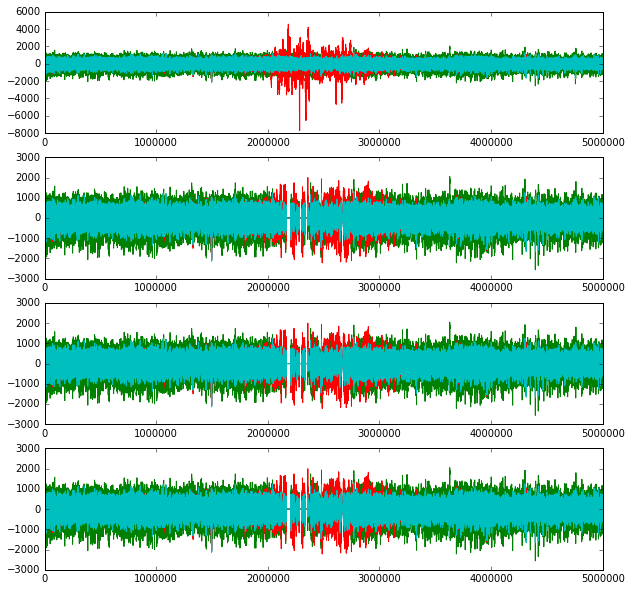

In [34]:
middle = 90000

delta = 5000000

start = int(middle - delta/2)

if start < 0:
    start = 0

stop = int (start + delta)
max_value = raw_data.shape[1] - 1

if stop > max_value:
    stop = max_value

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(411)
plt.plot(raw_data[:,start:stop].T)

ax = fig.add_subplot(412)
plt.plot(masked_data[:,start:stop].T)

ax = fig.add_subplot(413)
plt.plot(masked_data2[:,start:stop].T)

ax = fig.add_subplot(414)
plt.plot(masked_data3[:,start:stop].T)